# Image Captioning for Chest X-Rays

This project builds an **automatic image captioning system** for chest X-rays, aiming to generate meaningful radiology-style descriptions from medical images.

---

### 🔹 Workflow
1. **Image Feature Extraction**  
   - Use **CheXNet (DenseNet-121 pretrained on chest X-rays)** to extract deep image features.
2. **Text Preprocessing**  
   - Clean and tokenize radiology reports, build a word-to-index mapping, and pad sequences.
3. **Model Architecture**  
   - **Dual input model**:  
     - CNN features from images.  
     - Embedded sequences from reports.  
   - Combine both through an LSTM decoder to generate captions.
4. **Training & Evaluation**  
   - Trained on paired X-ray + report datasets.  
   - Evaluate using generated captions compared with ground truth.

---

### 📌 Datasets Used
- [CheXNet Weights](https://www.kaggle.com/datasets/sinamhd9/chexnet-weights)  
- [Chest X-rays Indiana University](https://www.kaggle.com/datasets/raddar/chest-xrays-indiana-university)  

---
Link to the paper: https://arxiv.org/abs/1502.03044

Great thanks : [Ebrahim Elgazar](https://www.kaggle.com/code/ebrahimelgazar/image-captioning-chest-x-rays)

**Goal:** Assist radiologists by automating report generation, improving efficiency and consistency in chest X-ray interpretation.

## Project Workflow

![Workflow](https://raw.githubusercontent.com/NufalXBaalash/Chest_X-ray_Image_Captioning/main/imgs/workflow.jpg)




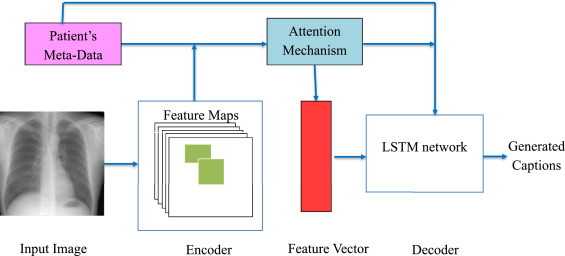

# 1. Import Libraries & Load Data
In this step, we import the required libraries (TensorFlow/Keras, NumPy, etc.) and load the datasets.  
We also bring in **CheXNet weights** and the **Indiana University Chest X-ray dataset** for feature extraction and captioning.


In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

2025-09-17 23:05:56.473851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758150356.707886      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758150356.777149      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
images = glob(image_path + "*.png")
len(images)

7470

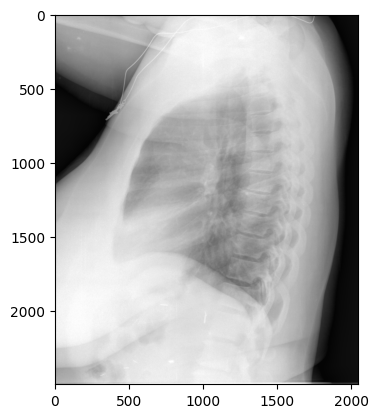

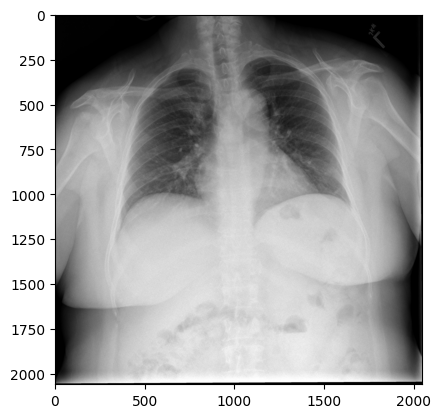

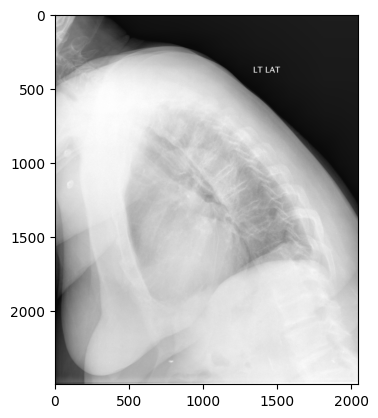

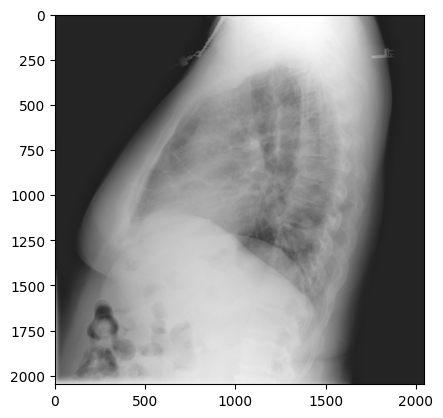

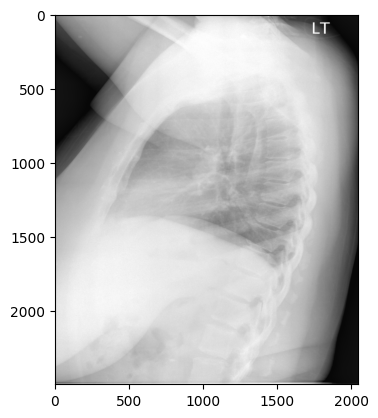

In [3]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

# 2. Text Preprocessing
Radiology reports are cleaned, tokenized, and converted into sequences.  
We also build a vocabulary and word-to-index mapping, then pad the sequences for training.


In [4]:
import re
# Read in the projections data
projections = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')

# Read in the reports data
reports = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Define the path to the images folder
images_folder = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

# Merge the projections and reports data on the UID column
reports = pd.merge(projections, reports, on='uid')

# Create a dictionary of image filenames and their corresponding captions
data = {}
for i in range(len(reports)):
    filename = reports.loc[i, 'filename']
    caption = reports.loc[i, 'impression']
    if filename not in data:
        data[filename] = []
    if isinstance(caption, str) and re.match(r'^\d+\.', caption):
        data[filename].append(caption.split('. ')[1])
    else:
        if data[filename]:
            data[filename][-1] += " " + caption
        else:
            data[filename].append(caption)

In [5]:
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            if isinstance(line1, str):
                for j in line1.split():
                    if len(j) < 2:
                        continue
                    j = j.lower()
                    lines += j + " "
                if key not in dict_2:
                    dict_2[key] = list()
                dict_2[key].append(lines)
    return dict_2

data2 = cleanse_data(data)
print(len(data2))

7414


In [6]:
# convert the following into a vocabulary of words and calculate the total words
def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

# summarize vocabulary
vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

1891


In [7]:
def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

# 3. Image Feature Extraction
Here we use **CheXNet (DenseNet-121 pretrained on Chest X-rays)** to extract deep features from each image.  
These features will act as the input representation of X-rays for our captioning model.


In [8]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5
/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv
/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/349_IM-1697-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/607_IM-2196-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2832_IM-1249-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/699_IM-2263-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1931_IM-0602-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/947_IM-2442-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2932_IM-1335-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2303_IM-0882-1001.dcm.png
/kaggle/input/chest-xrays-i

In [19]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
import numpy as np
import pickle
import os
from tqdm import tqdm
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential


def chexnet_sequential(input_shape=(224,224,3), num_classes=14, weights_path=None):
    base_model = DenseNet121(weights=None, include_top=False, input_shape=input_shape)

    if weights_path is not None:
        base_model.load_weights(weights_path, by_name=True)

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid', kernel_regularizer=l2(0.0001))
    ])

    return model

# Define input shape
input_shape = (224, 224, 3)

# Base model (without top layers)
base_model = DenseNet121(weights="imagenet", include_top=False, pooling="avg", input_shape=input_shape)

# Directory with chest X-ray images
img_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"
img_list = os.listdir(img_dir)

# Preallocate array for features
all_features = []
filenames = []

# Process in batches instead of one by one
batch_size = 32
num_batches = int(np.ceil(len(img_list) / batch_size))

for i in tqdm(range(num_batches), desc="Encoding images"):
    batch_files = img_list[i*batch_size : (i+1)*batch_size]
    batch_imgs = []

    for img_filename in batch_files:
        img_path = os.path.join(img_dir, img_filename)
        img = load_img(img_path, target_size=input_shape[:2])
        x = img_to_array(img)
        batch_imgs.append(x)
        filenames.append(img_filename)

    batch_imgs = np.array(batch_imgs)
    batch_imgs = preprocess_input(batch_imgs)

    # Extract features in one pass
    features = base_model.predict(batch_imgs, verbose=0)
    all_features.append(features)

# Stack all features
all_features = np.vstack(all_features)

# Map filename → feature vector
encoding = {fn: feat for fn, feat in zip(filenames, all_features)}

# Save features
with open("encodings.pkl", "wb") as f:
    pickle.dump(encoding, f)


Encoding images: 100%|██████████| 234/234 [06:09<00:00,  1.58s/it]


# 4. Vocabulary Building & Tokenization
In this step, we process all radiology captions to create a vocabulary and tokenizer:
- Count word frequencies and filter out rare words using a threshold.
- Build **word-to-index** and **index-to-word** mappings for model training.
- Save the tokenizer and mappings for reuse.
- Compute the **maximum caption length**, which will be needed for sequence padding.

✅ **Goal**: Prepare the text data in a structured format so the model can map image features to words effectively.


In [10]:
import pickle
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

# Gather all captions
all_train_captions = [cap for caps in data2.values() for cap in caps]
print(f"Total captions: {len(all_train_captions)}")

# Build word counts
word_counts = Counter(" ".join(all_train_captions).split())
print(f"Unique words before thresholding: {len(word_counts)}")

# Apply frequency threshold
word_count_threshold = 10
vocab = [w for w, c in word_counts.items() if c >= word_count_threshold]
print(f"Unique words after threshold {word_count_threshold}: {len(vocab)}")

# --- Use Keras Tokenizer instead of manual mapping ---
tokenizer = Tokenizer(num_words=len(vocab)+1, oov_token="<unk>")
tokenizer.fit_on_texts(all_train_captions)

# Word-to-index and index-to-word mappings
wordtoix = tokenizer.word_index
ixtoword = {v: k for k, v in wordtoix.items()}
vocab_size = len(wordtoix) + 1  # reserve 0 for padding
print(f"Final vocab size: {vocab_size}")

# Save tokenizer and mappings
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("wordtoix.pkl", "wb") as f:
    pickle.dump(wordtoix, f)

with open("ixtoword.pkl", "wb") as f:
    pickle.dump(ixtoword, f)

# --- Helper functions ---
def to_lines(descriptions):
    """Flatten dictionary of descriptions into list of sentences"""
    return [d for descs in descriptions.values() for d in descs]

def max_length(descriptions):
    """Find the maximum sentence length in tokens"""
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# Determine max length
max_len = max_length(data2)
print(f"Maximum description length: {max_len}")


Total captions: 7414
Unique words before thresholding: 1891
Unique words after threshold 10: 540
Final vocab size: 1357
Maximum description length: 124


# 5. Custom Data Generator
To efficiently feed data into the model, we implement a custom Keras `Sequence` class:

- **Inputs**:  
  - Image features (from CheXNet).  
  - Partial caption sequences (tokenized).  

- **Outputs**:  
  - The next word in the sequence.  

This setup enables the model to learn word-by-word caption generation while handling large datasets efficiently with batching.

✅ **Goal**: Create a generator that supplies the model with `(image, text_in)` → `text_out` training samples.


In [11]:
from tensorflow.keras.utils import Sequence
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

class CaptionDataGenerator(Sequence):
    def __init__(self, descriptions, photos, wordtoix, max_length, batch_size, **kwargs):
        super().__init__(**kwargs)  # important for Keras multiprocessing
        self.descriptions = descriptions
        self.photos = photos
        self.wordtoix = wordtoix
        self.max_length = max_length
        self.batch_size = batch_size

        # Precompute (image, in_seq, out_seq) triples
        self.data = []
        for key, desc_list in descriptions.items():
            for desc in desc_list:
                seq = [self.wordtoix[word] for word in desc.split() if word in self.wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                    self.data.append((key, in_seq, out_seq))

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_data = self.data[idx*self.batch_size:(idx+1)*self.batch_size]

        X1, X2, y = [], [], []
        for key, in_seq, out_seq in batch_data:
            X1.append(self.photos[key])
            X2.append(in_seq)
            y.append(out_seq)

        # ✅ Return inputs as a tuple, not a list
        return (np.array(X1), np.array(X2)), np.array(y)


# 6. Embedding Matrix with BERT
Instead of training word embeddings from scratch, we leverage a **pretrained Transformer (DistilBERT)** to build a rich embedding matrix:

- Load the pretrained **DistilBERT tokenizer & model**.
- For each word in our vocabulary, obtain its vector representation:
  - Tokenize the word.  
  - Pass through BERT.  
  - Use average pooling over subword tokens.  
- Store the vectors in an embedding matrix aligned with our vocabulary indices.

✅ **Goal**: Provide the captioning model with high-quality semantic embeddings that improve language understanding.


In [12]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Load pretrained Transformer model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

# Embedding dimension comes from the model
embedding_dim = bert.config.hidden_size
print("Embedding dim:", embedding_dim)

# Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype="float32")

# Build matrix: word → vector
for word, i in tqdm(wordtoix.items()):
    tokens = tokenizer(word, add_special_tokens=False, return_tensors="pt")
    with torch.no_grad():
        outputs = bert(**tokens)
        # Average pooling over subword tokens
        vector = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    embedding_matrix[i] = vector

print("Embedding matrix shape:", embedding_matrix.shape)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Embedding dim: 768


100%|██████████| 1356/1356 [00:17<00:00, 76.21it/s]

Embedding matrix shape: (1357, 768)


# 7. Captioning Model Architecture
We now define the **dual-input model** that combines image features with text sequences:

- **Image branch**  
  - Input: 1024-dimensional features extracted from CheXNet.  
  - Layers: Dropout → Dense (256 units, ReLU).  

- **Text branch**  
  - Input: Tokenized caption sequences (padded to max length).  
  - Layers: Pretrained **BERT embedding matrix** → Dropout → LSTM (256 units).  

- **Decoder**  
  - Merge (Add) image and text features.  
  - Dense layer (256 units, ReLU).  
  - Output: Softmax over the vocabulary (predict next word).  

✅ **Goal**: Train a model that learns to generate radiology-style captions conditioned on both the X-ray image and partial text.


In [13]:
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, add, Embedding
from tensorflow.keras.models import Model

# ✅ Image input branch
inputs1 = Input(shape=(1024,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# ✅ Text input branch (with Transformer-based embeddings)

# calculate max length once and store as integer
max_seq_length = max_length(data2)   

# Now use that in your Input layer
inputs2 = Input(shape=(max_seq_length,))
se1 = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_seq_length,   # use int not function
    mask_zero=True,
    trainable=True
)(inputs2)

se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# ✅ Decoder (combine image + text features)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# ✅ Final model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 124)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 124, 768)  │  1,042,176 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 124, 768)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 124)       │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    262,400 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │  1,049,600 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1357)      │    348,749 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,768,717 (10.56 MB)

 Trainable params: 2,768,717 (10.56 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Training the Model
We load precomputed image features, compile the model, set training parameters, and fit the model using the custom `CaptionDataGenerator`.


In [14]:
import tensorflow as tf
import pickle

# Load image encodings
features = pickle.load(open("encodings.pkl", "rb"))

# Compile model with sparse categorical crossentropy
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

epochs = 20
batch_size = 32   # Much bigger than 3
steps = len(data2) // batch_size

# Create generator
train_generator = CaptionDataGenerator(
    descriptions=data2,
    photos=features,
    wordtoix=wordtoix,
    max_length=max_seq_length,
    batch_size=batch_size
)

# Train with multiprocessing for faster data loading
model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    verbose=1,
)


Epoch 1/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 4.3959
Epoch 2/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2.8729
Epoch 3/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2.3997
Epoch 4/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2.0221
Epoch 5/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.8053
Epoch 6/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.5266
Epoch 7/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.3765
Epoch 8/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.2269
Epoch 9/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.0852
Epoch 10/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.9921
Epoch 11/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.9006
Epoch 12/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.8317
Epoch 13/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.7684
Epoch 14/20
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.7338
Epoch 15/20
138

In [15]:
model.save('model_' + "2" + '.keras')

# 9. Caption Generation
Load the trained model, image features, and word mappings.  
Select an image, run it through the caption generator with top-k sampling + temperature,  
and compare the predicted caption against the ground-truth description.


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pickle

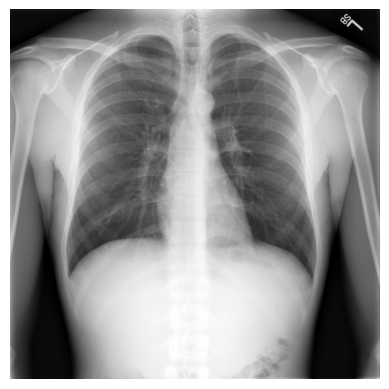

Generated Caption: prosthetic picc catheter tip mid svc small right there is no effusion or heart size lungs are no effusion or no effusion or heart size
Real Caption
['no acute cardiopulmonary abnormality identified. ']


In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

# --- Load trained model ---
model = load_model('model_2.keras', compile=False)  # compile=False avoids training-time constraints

# --- Load image features ---
features = pickle.load(open("encodings.pkl", "rb"))

# --- Load tokenizer mappings ---
with open("wordtoix.pkl", "rb") as f:
    words_to_index = pickle.load(f)

with open("ixtoword.pkl", "rb") as f:
    index_to_words = pickle.load(f)

# --- Parameters ---
images_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
max_length = 124  # same as used in training

# --- Caption generation ---
def Image_Caption(picture, max_steps=25, temperature=0.7, top_k=5):
    """
    Generate a caption for a given image feature vector.
    
    Args:
        picture (np.array): Precomputed image feature vector, shape (1, feature_dim)
        max_steps (int): Maximum number of words to generate
        temperature (float): Temperature for sampling (controls randomness)
        top_k (int): Number of top probable words to sample from
    
    Returns:
        str: Generated caption
    """
    in_text = 'startseq'
    generated_words = []

    for _ in range(max_steps):
        # Convert current text to sequence
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='pre')

        # Predict next word probabilities
        yhat = model([picture, sequence], training=False)
        probabilities = yhat.numpy().ravel()

        # Temperature scaling
        probabilities = np.exp(np.log(probabilities + 1e-9)/temperature)
        probabilities /= np.sum(probabilities)

        # Top-k sampling
        top_indices = np.argsort(probabilities)[-top_k:]
        top_probs = probabilities[top_indices] / np.sum(probabilities[top_indices])
        yhat_index = np.random.choice(top_indices, p=top_probs)

        word = index_to_words[yhat_index]

        # Stop conditions
        if word == 'endseq':
            break
        if word == 'xxxx':  # skip placeholder tokens
            continue
        # Avoid repeating the same word 3 times consecutively
        if len(generated_words) >= 2 and word == generated_words[-1] == generated_words[-2]:
            break

        generated_words.append(word)
        in_text += ' ' + word

    return ' '.join(generated_words)



# --- Pick an image ---
z = 2000
pic = list(features.keys())[z]
image_vector = features[pic].reshape((1, -1))  # shape (1, feature_dim)

# --- Display image ---
x = plt.imread(images_dir + pic)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.show()

# --- Generate caption ---
caption = Image_Caption(image_vector)
print("Generated Caption:", caption)

print("Real Caption")
print(data2[pic])

---

<div style="
    background: linear-gradient(135deg, #e6f0ff, #f9fbff);
    border: 2px solid #0077ff;
    border-radius: 12px;
    padding: 20px;
    text-align: center;
    font-family: 'Segoe UI', sans-serif;
    box-shadow: 0 4px 10px rgba(0,0,0,0.1);
    margin-top: 20px;
">

<h2 style="color:#0044cc; margin-bottom:10px;">🙏 Thanks for Reading!</h2>

<p style="font-size:16px; color:#333; margin: 10px 0;">
If you found this notebook helpful, please consider leaving an 
<span style="color:#0077ff; font-weight:bold;">upvote 💙</span>.  
</p>

<p style="font-size:15px; color:#444; margin: 10px 0;">
Your support motivates me to create and share more such notebooks!
</p>

</div>

---
